## Домашнее задание 8 ##
Выполнено Павлом Овчинниковым при обучении на курсе "A/B-тестирование (семинары)" ###
Преподаватель Доллорес Кусакина ###

Задание выолнено в VSCode 

## Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

### На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue. Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру. ### 



In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

import openpyxl 
import os 
import glob 
from openpyxl import load_workbook 
from openpyxl import Workbook 
import openpyxl.styles 

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [33]:
data = pd.read_excel('AB_Test_Results.xlsx')
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [34]:
# проверяем данные на пропущенные значения в наборе данных
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

пропушенных значений нет

In [35]:
# Находим пользователей, принесших доход
data[data['REVENUE'] > 0]

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


Сравниваем выборки variant и control между собой


In [36]:
data.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [37]:
data[data['VARIANT_NAME'] == 'variant'].describe()


,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


In [38]:
data[data['VARIANT_NAME'] == 'control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


Видим, что средний доход в группе control выше - 0.129013 vs 0.070070 в группе variant
и максимальная выручка отличается почти в 4 раза: в группе control 196.010000 vs 58.630000 в группе variant

Проведем тест Шапиро на нормальность распределения выборок при уровне значимости в 5%

In [39]:
from scipy.stats import shapiro
alpha = 0.05

st = shapiro(data.REVENUE)
print('Распределение {}нормальное\n'.format( {True:'НЕ ',
False:''}[st[1] < alpha]))

Распределение НЕ нормальное



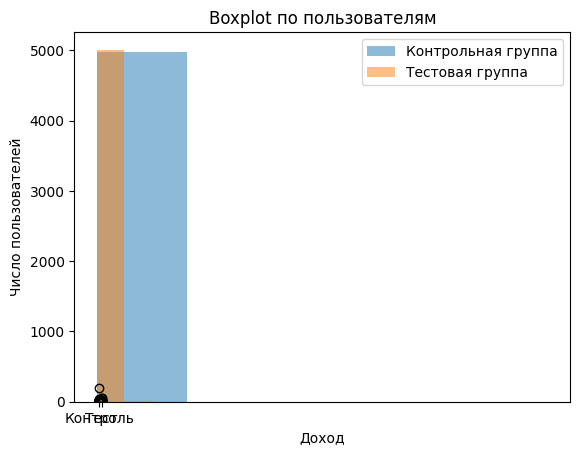

In [40]:
cont = data.query('VARIANT_NAME == "control"')
test = data.query('VARIANT_NAME == "variant"')

cont.REVENUE.hist(bins=5, alpha=0.5, label='Контрольная группа')
test.REVENUE.hist(bins=5, alpha=0.5, label='Тестовая группа')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend()

plt.boxplot([cont.REVENUE, test.REVENUE],
            labels=['Контроль', 'Тест'],
            widths=0.5
            )
plt.title('Boxplot по пользователям', loc='center')
plt.grid(axis='both')


In [41]:
ttest_ind(cont.REVENUE.values, test.REVENUE.values, equal_var = False)

TtestResult(statistic=1.268403803110966, pvalue=0.20469713432410774, df=6811.174610031575)

In [42]:
C_mean = cont.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()
C_std = cont.REVENUE.values.std()
T_std = test.REVENUE.values.std()

n =  len(cont.REVENUE.values)
S = np.sqrt((T_std**2 + C_std **2)/ 2)
ef =float((T_mean-C_mean)/ S) 
from statsmodels.stats.power import TTestIndPower

alpha = 0.05
effect = 0.02

analysis = TTestIndPower()
result = analysis.solve_power(effect, power = None,
nobs1 = n, ratio = 1.0, alpha = alpha)

result

0.16965671280283606

Выводы и Рекомендация менеджеру: статистически значимых различий нет, поэтому сохраняем гипотезу о том, что на тестовую групппу изменения не повлияли. Необходимо проверить корректность проделанного эксперимента и не выкатывать обновление в продакшн.